In [1]:
import sys
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import Counter
from torch.utils.data import Dataset, DataLoader
from classic_mil import Feature_attention
from sklearn.metrics import roc_auc_score, roc_curve, mean_squared_error
from sklearn.metrics import precision_recall_curve, average_precision_score, cohen_kappa_score
from sklearn.preprocessing import label_binarize
from sklearn.metrics import auc as calc_auc
import random
import glob
import h5py
import shutil

from sklearn.metrics import f1_score, precision_recall_curve
from sklearn.metrics import classification_report

from matplotlib import patches

#import scienceplots
import seaborn as sns

from torchvision.models import resnet50
import copy
import torchvision.transforms as transforms

from omegaconf import OmegaConf

In [2]:
if torch.cuda.is_available():
    DEVICE = 'cuda:1' 
else:
    DEVICE = 'cpu'
print("Device:", DEVICE)

Device: cuda:1


In [3]:
conf_preproc = OmegaConf.load("../../conf/preproc.yaml")
conf_preproc = conf_preproc["classic_mil_on_embeddings_bag"]["tcga_brca_224_224_patches_jmcs"]

conf_train = OmegaConf.load("sote_conf_train_rev.yaml")

## Load models from CV folds

In [4]:
best_models_on_val_loss = np.array(glob.glob("saved_sote_models_uni_finetuned_val_loss_rev/*.pt"))
#best_models_on_val_auc = np.array(glob.glob("saved_sote_models_uni_finetuned_val_auc_rev/*.pt"))

In [5]:
best_models_on_val_loss
#best_models_on_val_auc

array(['saved_sote_models_uni_finetuned_val_loss_rev/epoch_9_trainloss_0.651_valloss_0.652_auc_0.628_0.7_0.677_0.507_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_15_trainloss_0.607_valloss_0.613_auc_0.644_0.726_0.639_0.569_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_31_trainloss_0.509_valloss_0.544_auc_0.712_0.767_0.626_0.743_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_24_trainloss_0.564_valloss_0.614_auc_0.671_0.75_0.717_0.546_checkpoint.pt',
       'saved_sote_models_uni_finetuned_val_loss_rev/epoch_39_trainloss_0.429_valloss_0.492_auc_0.769_0.894_0.71_0.702_checkpoint.pt'],
      dtype='<U125')

In [6]:
np.mean([float(e.split('_auc_')[-1].split("_")[0]) for e in best_models_on_val_loss])
#np.mean([float(e.split('_auc_')[-1].split("_")[0]) for e in best_models_on_val_auc])

0.6848000000000001

## Load biopsy bags -> input data

In [ ]:
biopsy_bag_input_path = conf_preproc.uni_finetuned_biopsy_dir_macenko

biopsy_df_local_test = pd.read_csv("<YOUR_PATH>/cv_splits_tcga/tcga-brca_test.csv")
biopsy_df_local_test.sort_values('biopsy_id', inplace=True)
biopsy_bag_input_files_local_test = np.array( sorted([ biopsy_bag_input_path+i+'.h5' for i in biopsy_df_local_test.biopsy_id.values ]) )

biopsy_bag_input_files_local_test.shape, biopsy_bag_input_files_local_test[:3]

## Predict with UNI-FT-MIL model ensemble

In [8]:
def load_h5_file_biopsy_bag(filename):
    with h5py.File(filename, "r") as f:
        features = f['features'][()]
        coords = f['coords'][()]
        slides = f['slides'][()]
        label = f['label'][()]
        return features, coords, slides, label

In [9]:
def plot_roc(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        # try to one-hot encode y_true
        y_true = F.one_hot(torch.from_numpy(y_true).to(torch.int64), 4)

    plt.figure(figsize=(6, 6))
    auc_all = []
    for class_ind in range(y_pred.shape[-1]):
        fpr, tpr, _ = roc_curve(y_true[:, class_ind], y_pred[:, class_ind])
        auc = roc_auc_score(y_true[:, class_ind], y_pred[:, class_ind])
        auc_all.append(auc)
        plt.plot(fpr, tpr, '-', label='AUC : %.3f, label : %d' % (auc, class_ind+1))
    plt.legend()
    plt.show()
    return auc_all

In [10]:
def plot_precision_recall(y_true, y_pred):
    if y_pred.shape != y_true.shape:
        # One-hot encode y_true
        y_true = label_binarize(y_true, classes=range(y_pred.shape[-1]))

    plt.figure(figsize=(6, 6))
    ap_all = []
    for class_ind in range(y_pred.shape[-1]):
        precision, recall, _ = precision_recall_curve(y_true[:, class_ind], y_pred[:, class_ind])
        average_precision = average_precision_score(y_true[:, class_ind], y_pred[:, class_ind])
        ap_all.append(average_precision)
        plt.plot(recall, precision, '-', label='AP: %.3f, Label: %d' % (average_precision, class_ind))
    plt.legend()
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.show()
    return ap_all

In [11]:
def pred_with_one_model(model, biopsy_bag_input_files):
    
    preds_all = []
    labels_all = []
    att_weight_all = []

    for b in range(biopsy_bag_input_files.shape[0]):

        with torch.no_grad():
            
            emb_npy, coords, slides, labels = load_h5_file_biopsy_bag( biopsy_bag_input_files[b] )
            #emb_npy = np.load( biopsy_bag_input_files[b] )['embedding']

            #if emb_npy.shape[0] > 15000:
            #    rand_idx = np.random.permutation(emb_npy.shape[0])
            #    emb_npy = emb_npy[rand_idx[:15000]]

            emb = torch.from_numpy(np.expand_dims(emb_npy, 0).astype(np.float32)).to(DEVICE)
            _, preds, label, att_weight = model(emb)


        preds_all.append(preds.cpu().detach().numpy())
        labels_all.append(label.cpu().numpy())
        att_weight_all.append(att_weight.cpu().numpy().flatten())
        
    preds_all = np.concatenate(preds_all)
    labels_all = np.concatenate(labels_all)
    
    return preds_all, labels_all, att_weight_all

### Local test set

In [12]:
best_models_on_selected_metric = best_models_on_val_loss

#best_models_on_selected_metric = best_models_on_val_auc

In [13]:
nr_models = best_models_on_selected_metric.shape[0]

preds_ensemble_local_test = np.zeros((best_models_on_selected_metric.shape[0], biopsy_bag_input_files_local_test.shape[0], 3))
labels_ensemble_local_test = np.zeros((best_models_on_selected_metric.shape[0], biopsy_bag_input_files_local_test.shape[0], 1))
att_weights_local_test = [] # np.zeros((best_models_on_selected_metric.shape[0], biopsy_bag_input_files_local_test.shape[0], 1), dtype=object)


for m in tqdm(range(nr_models)):
    
    model = Feature_attention( conf_train.emb_dim, 
                               conf_train.hidden_dim, 
                               conf_train.att_hidden_dim,
                               conf_train.dropout_fc,
                               conf_train.dropout_attn, 
                               conf_train.n_classes).to(DEVICE)
    best_model_path = best_models_on_selected_metric[m] # path of the m th best model
    print(os.path.basename(best_model_path))
    model_state_dict = torch.load(best_model_path, map_location=torch.device('cpu'), weights_only=True) # load

    model.load_state_dict(model_state_dict) # load weights
    model.eval() # set to eval mode ! 
    model.to(DEVICE)
    
    preds_all, labels_all, att_weights_all = pred_with_one_model(model, biopsy_bag_input_files_local_test)
    
    preds_ensemble_local_test[m] = preds_all
    labels_ensemble_local_test[m] = labels_all
    att_weights_local_test.append(att_weights_all)
    
att_weights_local_test = np.array( att_weights_local_test, dtype=object)

  0%|          | 0/5 [00:00<?, ?it/s]

epoch_9_trainloss_0.651_valloss_0.652_auc_0.628_0.7_0.677_0.507_checkpoint.pt


 20%|██        | 1/5 [00:05<00:22,  5.52s/it]

epoch_15_trainloss_0.607_valloss_0.613_auc_0.644_0.726_0.639_0.569_checkpoint.pt


 40%|████      | 2/5 [00:11<00:16,  5.51s/it]

epoch_31_trainloss_0.509_valloss_0.544_auc_0.712_0.767_0.626_0.743_checkpoint.pt


 60%|██████    | 3/5 [00:16<00:10,  5.39s/it]

epoch_24_trainloss_0.564_valloss_0.614_auc_0.671_0.75_0.717_0.546_checkpoint.pt


 80%|████████  | 4/5 [00:21<00:05,  5.43s/it]

epoch_39_trainloss_0.429_valloss_0.492_auc_0.769_0.894_0.71_0.702_checkpoint.pt



00%|██████████| 5/5 [00:27<00:00,  5.41s/it]

In [14]:
preds_ensemble_local_test.shape, labels_ensemble_local_test.shape, att_weights_local_test.shape

((5, 678, 3), (5, 678, 1), (5, 678))

In [15]:
np.save('preds_sote_5ensemble_level4_macenko_uni_finetuned_run_sote_sqrt_paper_rev_tuned_val_loss_tcga_brca_rev.npy', preds_ensemble_local_test)

In [16]:
preds_ensemble_local_test = np.load('preds_sote_5ensemble_level4_macenko_uni_finetuned_run_sote_sqrt_paper_rev_tuned_val_loss_tcga_brca_rev.npy')


#### Simple mean

In [17]:
final_pred_ensemble_local_test = np.mean(preds_ensemble_local_test, axis=0)
final_label_ensemble_local_test = np.argmax(preds_ensemble_local_test, axis=-1)
final_pred_ensemble_local_test.shape, final_label_ensemble_local_test.shape

((678, 3), (5, 678))

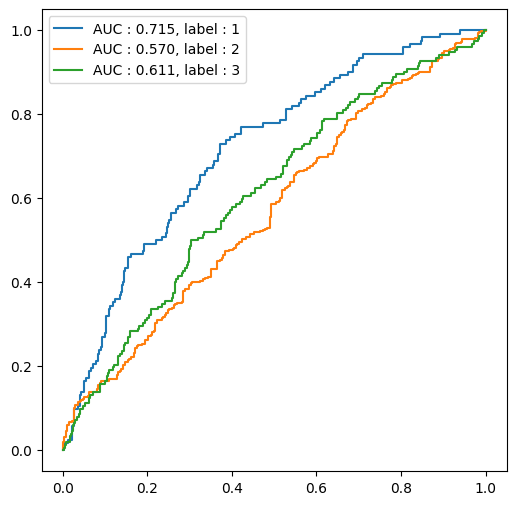

0.6320565030985542


In [18]:
auc_scores = plot_roc( biopsy_df_local_test.stage.values-1, final_pred_ensemble_local_test  )
print( np.mean(auc_scores) )

In [19]:
roc_auc_score( biopsy_df_local_test.stage.values-1, final_pred_ensemble_local_test, average="macro",  multi_class='ovr')

0.6320565030985542

In [20]:
roc_auc_score( biopsy_df_local_test.stage.values-1, final_pred_ensemble_local_test, average="weighted",  multi_class='ovr')

0.605388379234456